# Задание

Вам предлагается решить задачу от kaggle
https://www.kaggle.com/competitions/silero-audio-classifier/overview


От вас не требуется решить задачу с максимальным качеством. В этом задании мы хотим посмотреть на ваши умения:

1. писать чистый код
2. оставлять комментарии к своему коду (на русском или английском)
3. создавать и обучать нейронные сети

Для решения здачи можете выбрать один из фреймворков для обучение нейронных сетей  **pytorch** или **tensorflow**

В качестве решения вам нужно послать:

1. Jupyter notebook, который мы сможем запустить без ошибок и получить обученную модель изменив только пути до данных. **Важно** зафиксируйте random_state при семплировании данных в решении
2. Вашу обученную модель, сохраненную в любом удобном для вас формате




## Посмотрите на данные, с которыми вам предстоит работать

Можете взять код из kaggle соревнования или написать свой

## Спроектируйте модель

Не используйте pretrained модели. Создайте архитектуру модели с нуля. Можете использовать любые слои в любом количестве

Импортируем необходимые библиотеки

In [1]:
import os
import torch
import librosa
import torchaudio
import numpy as np
import pandas as pd
from typing import Any, List, Tuple
from glob import glob
from tqdm import tqdm
from torch import nn, Tensor
from pathlib import Path
from librosa import display
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from IPython.display import HTML, Audio, display_html, clear_output
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
torch.__version__, librosa.__version__, torchaudio.__version__

('1.11.0', '0.9.2', '0.11.0')

In [3]:
label_dict = {
    'speech': 0,
    'music': 1,
    'noise': 2    
}

In [4]:
data_folder = '../../kaggle/input/silero-audio-classifier'

In [5]:
def read_audio(path) -> np.ndarray:
    sr, wav = read(path)
    assert sr == 16000
    assert len(wav) == 16000 * 3
    assert len(wav.shape) == 1
    return wav


def read_audio_norm(path) -> np.ndarray:
    wav = read_audio(path)
    abs_max = np.abs(wav).max()
    wav = wav.astype('float32')
    if abs_max > 0:
        wav *= 1 / abs_max
    return wav

Прочитаем наши данные

In [6]:
train_path = Path(data_folder) / 'train'
df = pd.read_csv(Path(data_folder) / 'train.csv')
df['target'] = df['label'].apply(lambda x: label_dict.get(x, -1))

assert set([os.path.relpath(path, data_folder + '/train') 
            for path 
            in glob(f'{train_path}/train/*/*.wav')]) == set(df.wav_path.values)

df['wav_path'] = df['wav_path'].apply(lambda x: str(Path(data_folder) / Path('train') / x))

Создадим удобный класс нашего датасета

In [7]:
class CustomDataset(Dataset):
    """
    Dataset for sampling audio 
    Attributes:
        sample_df: Dataframe with labels and paths to audio.
        transform: If True apply MelSpectrogram to raw audio.
    """
    def __init__(self, sample_df, transform=False) -> None:
        self.sample_df = sample_df
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.sample_df)
    
    def __getitem__(self, idx) -> Tuple[Tensor, Tensor]:
        audio = read_audio(self.sample_df.wav_path[idx])
        class_id = self.sample_df.target[idx]
        input_audio = torch.from_numpy(audio).float()
        class_id = torch.tensor(class_id)
        if self.transform:
            mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024,win_length=1024,
                                                            hop_length=256, n_mels=64, center=True)
            input_audio = mel_spec(input_audio)
            input_audio = input_audio.clamp(min=1e-5).log()
        input_audio = input_audio.unsqueeze(0)
        return input_audio, class_id

Возьмем лишь часть данных для более быстрого обучения и создадим даталоадеры

In [8]:
df_sample = df.sample(n=50000, random_state=1)
train_df, val_df = train_test_split(df_sample, test_size=0.15, shuffle=True, random_state=1, stratify=df_sample.target)
train_df = train_df.reset_index()
val_df = val_df.reset_index()

train_dataset = CustomDataset(train_df, transform=False)
val_dataset = CustomDataset(val_df, transform=False)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    pin_memory=True,
    num_workers=2,
    shuffle=False
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=64, 
    pin_memory=True, 
    num_workers=2, 
    shuffle=False
)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [1]:
def show_progress(t, train_loss, val_loss, train_acc, val_acc) -> None:
    """
    Function for logging metrics on the plot updating it every epoch.
    """
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    
    ax1.plot(range(t), train_loss, c='darkblue', lw=3, label='train')
    ax1.plot(range(t), val_loss, c='green', marker='o', lw=5, label='valid')
    ax1.legend()
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.set_ylabel('accuracy')
    
    ax2.plot(range(t), train_acc, c='darkblue', lw=3, label='train')
    ax2.plot(range(t), val_acc, c='green', marker='o', lw=5, label='valid')
    ax2.legend()
    plt.show()

## Создайте метод train

Постарайтесь логировать как можно больше полезной информации в процессе обучения

In [10]:
def run_epoch(model, dataloader, criterion, device='cpu', optimizer=None,
              do_train=True, scheduler=None) -> Tuple[Tensor, Tensor, List]:
    loss_log, preds, gts = [], [], []
    model.train(do_train)

    for x_batch, y_batch in tqdm(dataloader, position=0):
        data = x_batch.to(device)
        target = y_batch.to(device)
        
        if do_train:
            optimizer.zero_grad()

        with torch.inference_mode(not do_train):
            output = model(data)
            loss = criterion(output, target).cpu()
            
        preds.append(output.detach().cpu())
        gts.append(y_batch.detach().cpu())
        loss_log.append(loss.item())
        
        if not do_train:
            continue
        
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
    return torch.cat(gts), torch.cat(preds), loss_log
    
def train(model, dataloaders, optimizer, criterion, n_epochs, device='cpu', scheduler=None) -> None:
    prefix = 'Full val - {}'
    train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []
    for epoch in tqdm(range(n_epochs), position=0):
        print("Epoch {0} of {1}".format(epoch, n_epochs))

        train_targets, train_preds, train_loss, = run_epoch(
            model=model,
            dataloader=dataloaders['train'],
            criterion=criterion, 
            optimizer=optimizer,
            do_train=True,
            scheduler=scheduler,
            device=device,
        )
        train_score = accuracy_score(train_targets, np.argmax(train_preds, axis=1))

        val_targets, val_preds, val_loss = run_epoch(
            model=model,
            dataloader=dataloaders['val'],
            criterion=criterion, 
            optimizer=None,
            do_train=False,
            scheduler=None,
            device=device,
        )
        val_score = accuracy_score(val_targets, np.argmax(val_preds, axis=1))
            
        train_loss_history.append(np.array(train_loss).mean())
        val_loss_history.append(np.array(val_loss).mean())
        train_acc_history.append(train_score)
        val_acc_history.append(val_score)
        
        show_progress(epoch + 1, train_loss_history, val_loss_history, train_acc_history, val_acc_history)

def inference(model, dataloader, device='cpu') -> Tensor:
    preds = []
    model.eval()
    for x_batch in tqdm(dataloader):
        data = x_batch[0].to(device)
        with torch.inference_mode():
            output = model(data)
            preds.append(output.detach().cpu())
            
    return torch.cat(preds)

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_size, pool_size, p=0.1, last_block=False) -> None:
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_size)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=conv_size)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool1d(kernel_size=pool_size)
        self.dropout = nn.Dropout(p=p)
        self.last_block = last_block
        
    def forward(self, x) -> Any:
        x = self.conv1(x)
        
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        if self.last_block:
            x, _ = torch.max(x, dim=2)
        else:
            x = self.pooling(x)
        out = self.dropout(x)
        return out

Для начала обучим модель на сырых аудио

In [12]:
class SimpleWaVNet(nn.Module):
    def __init__(self) -> None:
        super(SimpleWaVNet, self).__init__()
        
        self.block1 = ConvBlock(in_channels=1, out_channels=16, conv_size=9, pool_size=16)
        self.block2 = ConvBlock(in_channels=16, out_channels=32, conv_size=3, pool_size=4)
        self.block3 = ConvBlock(in_channels=32, out_channels=64, conv_size=3, pool_size=4)
        self.block4 = ConvBlock(in_channels=64, out_channels=256, conv_size=3, pool_size=4, last_block=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(256, 64)
        self.linear2 = nn.Linear(64, 3)
        
    def forward(self, x) -> Any:
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.linear1(x)
        x = self.relu(x)
        out = self.linear2(x)
        return out

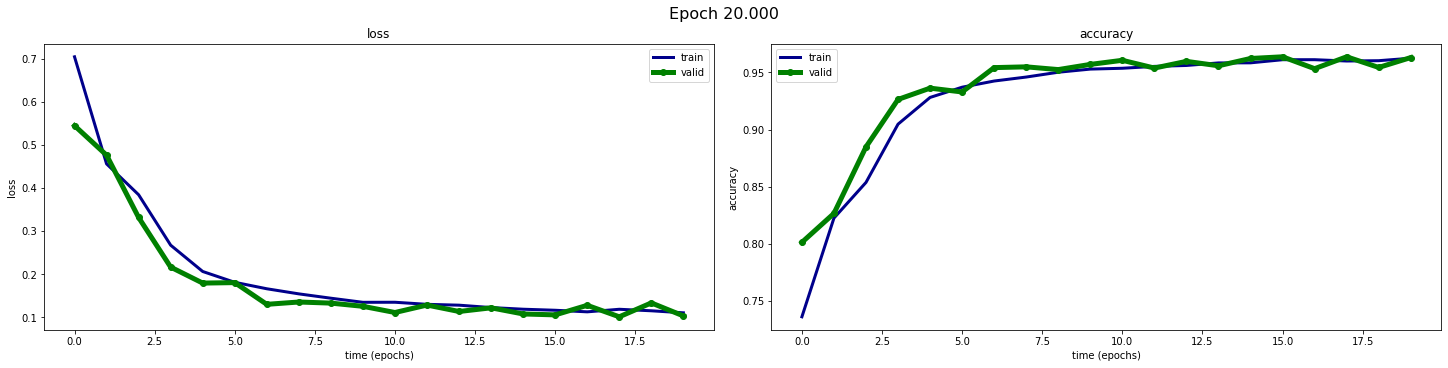

100%|██████████| 20/20 [15:20<00:00, 46.03s/it]


In [13]:
n_epochs = 20
model1d = SimpleWaVNet()
model1d.to(device)
optimizer = torch.optim.Adam(model1d.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
train(model1d, dataloaders, optimizer, criterion, n_epochs=n_epochs, device=device)

Доля правильных ответов порядка 0.95, неплохо, но попробуем улучшить результат, обучив модель на Мел-Спектрограммах

In [14]:
class MelSpecNet(nn.Module):
    def __init__(self) -> None:
        super(MelSpecNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, (11, 11), (4, 4), (2, 2)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),

            nn.Conv2d(64, 192, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),

            nn.Conv2d(192, 384, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.Conv2d(384, 256, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(4096, 128),
            nn.ReLU(True),
            nn.Linear(128, 3),
        )

    def forward(self, x) -> Any:
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


In [15]:
train_dataset = CustomDataset(train_df, transform=True)
val_dataset = CustomDataset(val_df, transform=True)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    pin_memory=True,
    num_workers=2,
    shuffle=False
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=64, 
    pin_memory=True, 
    num_workers=2, 
    shuffle=False
)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

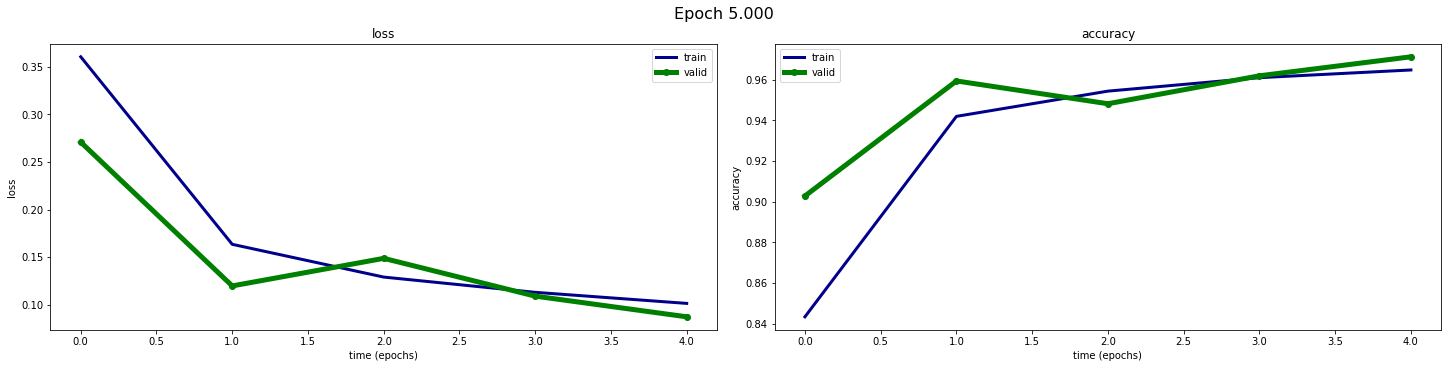

100%|██████████| 5/5 [07:26<00:00, 89.28s/it]


In [16]:
n_epochs = 5
model2d = MelSpecNet()
model2d.to(device)
optimizer = torch.optim.Adam(model2d.parameters(), lr=5e-5, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
train(model2d, dataloaders, optimizer, criterion, n_epochs=n_epochs, device=device)

Качество 0.96, отлично, но попробуем построить модель серьезнее, например, WideResNet

In [17]:
def conv3x3(in_planes, out_planes, stride=1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                    padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                    bias=False)


class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, dropout, stride=1) -> None:
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.dropout = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.relu = nn.ReLU(inplace=True)
        if stride != 1 or inplanes != planes:
            self.shortcut = conv1x1(inplanes, planes, stride)
            self.use_conv1x1 = True
        else:
            self.use_conv1x1 = False

    def forward(self, x) -> Any:
        out = self.bn1(x)
        out = self.relu(out)

        if self.use_conv1x1:
            shortcut = self.shortcut(out)
        else:
            shortcut = x

        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out += shortcut

        return out


class WideResNet(nn.Module):
    def __init__(self, depth, width, num_classes=10, dropout=0.3) -> None:
        super(WideResNet, self).__init__()

        layer = (depth - 4) // 6

        self.inplanes = 16
        self.conv = conv3x3(1, 16)
        self.layer1 = self._make_layer(16 * width, layer, dropout)
        self.layer2 = self._make_layer(32 * width, layer, dropout, stride=2)
        self.layer3 = self._make_layer(64 * width, layer, dropout, stride=2)
        self.bn = nn.BatchNorm2d(64 * width)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64 * width, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data = nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, planes, blocks, dropout, stride=1) -> nn.Sequential:
        layers = []
        for i in range(blocks):
            layers.append(BasicBlock(self.inplanes, planes, dropout, stride if i == 0 else 1))
            self.inplanes = planes

        return nn.Sequential(*layers)

    def forward(self, x) -> Any:
        x = self.conv(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.bn(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [18]:
train_dataset = CustomDataset(train_df, transform=True)
val_dataset = CustomDataset(val_df, transform=True)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    pin_memory=True,
    num_workers=2,
    shuffle=False
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=64, 
    pin_memory=True, 
    num_workers=2, 
    shuffle=False
)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

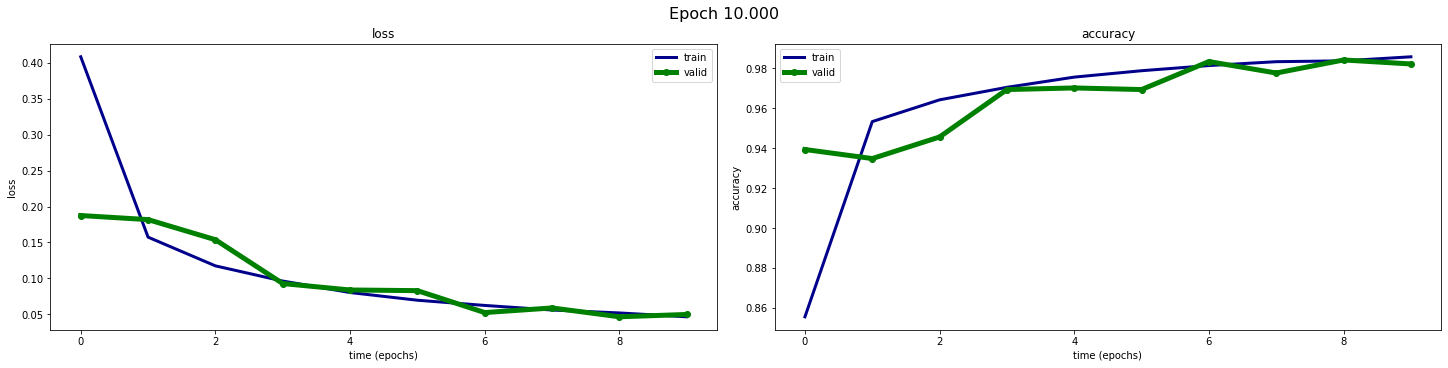

100%|██████████| 10/10 [30:23<00:00, 182.40s/it]


In [19]:
n_epochs = 10
model2d_modified = WideResNet(22, 2, num_classes=3, dropout=0.2)
model2d_modified.to(device)
optimizer = torch.optim.Adam(model2d_modified.parameters(), lr=5e-5, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
train(model2d_modified, dataloaders, optimizer, criterion, n_epochs=n_epochs, device=device)

Прекрасно, качество 0.98 куда лучше смотрится. Пожалуй, остановимся на этом. Сохраним наши модели

In [20]:
torch.save(model1d.state_dict(), 'model1d.pt')
torch.save(model2d.state_dict(), 'model2d.pt')
torch.save(model2d_modified.state_dict(), 'model2d_modified.pt')

Ссылка на модели: https://drive.google.com/drive/folders/1yP7AEu6OqiF5jUjVnnVbWHJg8OMM0bjM?usp=share_link

Если очень хочется, то можно отдельно провалидировать какую-нибудь модель, например так

In [ ]:
# preds = inference(model1d, val_dataloader, device=device)
# true = np.array([])
# for X, y in val_dataloader:
#     true = np.concatenate((true, y.flatten().numpy()), axis=None)
# accuracy_score(true, np.argmax(preds, axis=1))